In [ ]:
import matplotlib.pyplot as plt
import json
import os

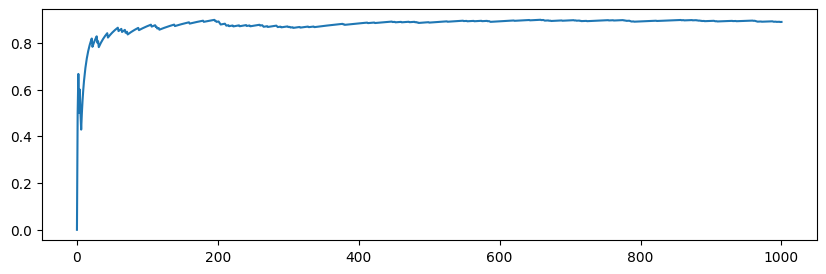

In [6]:
data = json.load(open("gold/openai/gpt-4.1-mini/medqa.json"))["correct_rate"]

plt.figure(figsize=(10, 3))
plt.plot(data)
plt.show()

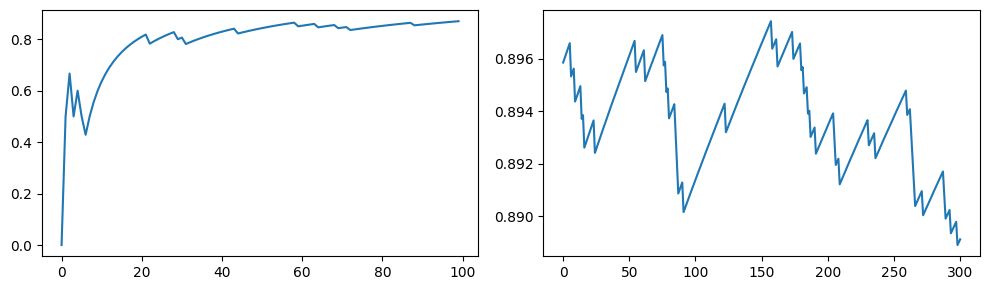

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(data[0:100])
axes[1].plot(data[700:])
plt.tight_layout()  
plt.show()

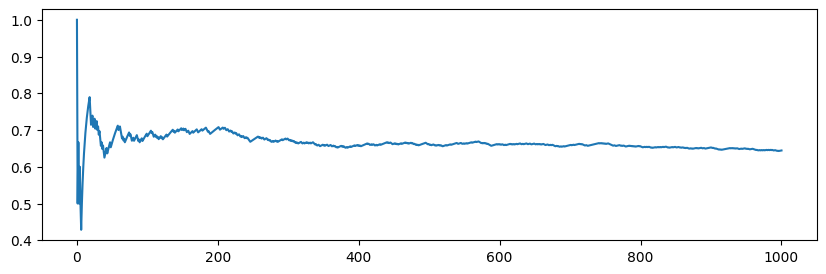

In [2]:
data = json.load(open("a/Llama-3.1-8B.json"))["correct_rate"]

plt.figure(figsize=(10, 3))
plt.plot(data)
plt.show()

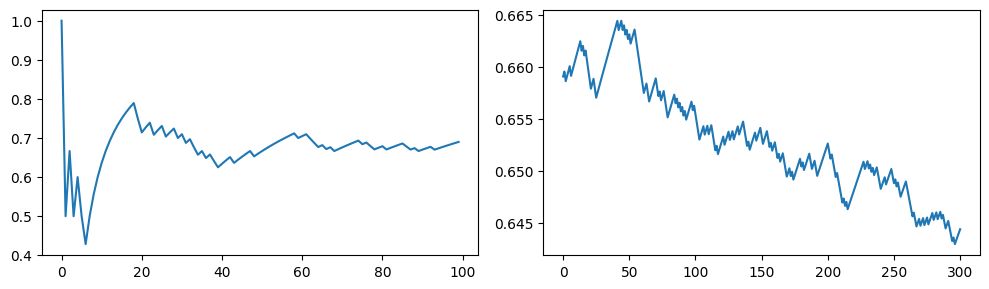

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(data[0:100])
axes[1].plot(data[700:])
plt.tight_layout()  
plt.show()

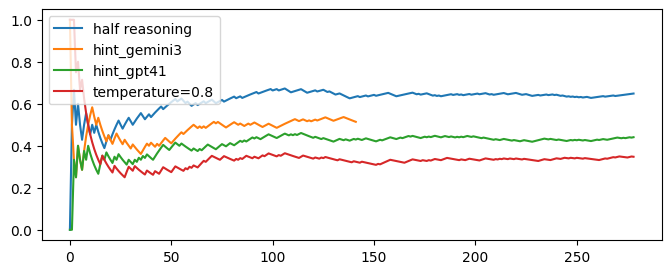

In [3]:
half_reasoning = json.load(open("gold/half_reasoning279.json"))["correct_rate"]
by_hint_gemini3 = json.load(open("gold/by_hint_gemini3.json"))["correct_rate"]
by_hint_gpt41 = json.load(open("gold/by_hint_gpt41.json"))["correct_rate"]
temper8 = json.load(open("gold/no_augment.json"))["correct_rate"]

plt.figure(figsize=(8, 3))
plt.plot(half_reasoning, label="half reasoning")

plt.plot(by_hint_gemini3, label="hint_gemini3")
plt.plot(by_hint_gpt41, label="hint_gpt41")

plt.plot(temper8, label="temperature=0.8")

plt.legend()
plt.show()

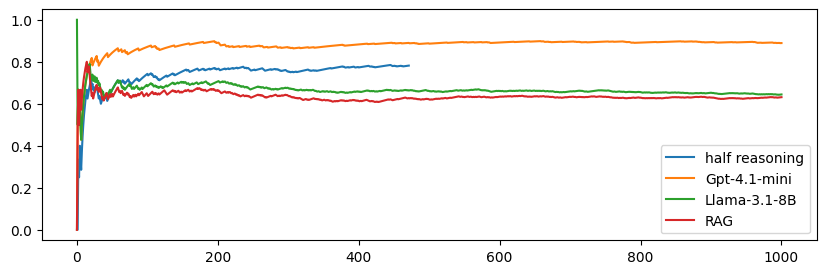

In [3]:
half_reasoning = json.load(open("gold/half_reasoning.json"))["correct_rate"]
chatgpt_qa = json.load(open("gold/Gpt-4.1-mini.json"))["correct_rate"]
llama_qa = json.load(open("gold/Llama-3.1-8B.json"))["correct_rate"]
rag_qa = json.load(open("gold/rag.json"))["correct_rate"]

plt.figure(figsize=(10, 3))
plt.plot(half_reasoning, label="half reasoning")

plt.plot(chatgpt_qa, label="Gpt-4.1-mini")
plt.plot(llama_qa, label="Llama-3.1-8B")
plt.plot(rag_qa, label="RAG")

plt.legend()
plt.show()

In [ ]:
from a.openrouter_client import OpenRouterClient 
model_choice = "openai/gpt-4.1-mini"
client = OpenRouterClient(api_key='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', 
                            model=model_choice, 
                            max_tokens=100)

qa_set = json.load(open("gold/QAmedqa.json"))

q_id = "0001"
q = f'question: {qa_set[q_id]["question"]} \noptions: {qa_set[q_id]["options"]},'
a = qa_set[q_id]['answer']
llm_a = client.answer_question(q)
print(llm_a)


[
"step_by_step_thinking": "The patient has transitional cell carcinoma of the bladder and developed sensorineural hearing loss soon after chemotherapy. Among chemotherapeutic agents used for bladder cancer, cisplatin is commonly used in neoadjuvant settings. Cisplatin is known to cause ototoxicity, leading to sensorineural hearing loss. The mechanism of action of cisplatin is cross-linking of DNA, which interferes with DNA replication and transcription, ultimately causing cancer cell death


In [1]:
from retriever import CLSEmbedding, SemanticRetriever
import json

embedder = CLSEmbedding(model_dir="BAAI/bge-m3")
retriever = SemanticRetriever(embedder)

questions = json.load(open("gold/QAmedqa.json"))
questions = [f"question: {q['question']}\noptions: {q['options']}" for id, q in questions.items()]
corpus = json.load(open("gold/textbooks/corpus_1000.json"))
corpus = [c["contents"] for c in corpus[:10]]

retriever.build_index(corpus)
results = retriever.retrieve(
    query=questions[0],
    top_k=5
)
for r in results:
    print(r)

shift = retriever.compute_embedding_shift_metrics(
    context1="The resident should prioritize transparency and honesty in patient care. Failing to disclose the complication to the patient and omitting it from the operative report could lead to a lack of informed consent and potential future complications. The attending's suggestion to withhold this information is unethical. The resident should stand up for what is right and report the incident to the attending, explaining the importance of transparency. If the attending continues to insist on withholding the information, the resident should consider reporting the incident to the hospital's ethics committee. The resident should not refuse to dictate the operative report, as this would compromise the accuracy of the medical record.",
    context2="The resident faces an ethical dilemma where the attending instructs not to disclose a procedural error and to omit it from the operative report. Transparency, honesty, and accurate medical documentation are critical ethical and legal obligations in medical practice. Failure to document such events can have serious consequences for patient safety, trust, and future care. The correct approach is to disclose the error to the patient and include it in the operative report, ensuring the patient is informed and the documentation reflects what occurred. Confrontation or refusal to dictate without addressing the ethical issue may not resolve the problem adequately. Reporting directly to the ethics committee might be premature without first trying to follow appropriate disclosure and documentation practices. Therefore, the best next step is to be honest with the patient and document the complication properly."
)
print(shift)

/opt/anaconda3/envs/raptor_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'text': 'Anatomy_Gray. What is anatomy? Anatomy includes those structures that can be seen grossly (without the aid of magnification) and microscopically (with the aid of magnification). Typically, when used by itself, the term anatomy tends to mean gross or macroscopic anatomy—that is, the study of structures that can be seen without using a microscopic. Microscopic anatomy, also called histology, is the study of cells and tissues using a microscope. Anatomy forms the basis for the practice of medicine. Anatomy leads the physician toward an understanding of a patient’s disease, whether he or she is carrying out a physical examination or using the most advanced imaging techniques. Anatomy is also important for dentists, chiropractors, physical therapists, and all others involved in any aspect of patient treatment that begins with an analysis of clinical signs. The ability to interpret a clinical observation correctly is therefore the endpoint of a sound anatomical understanding.', 'si

In [ ]:
import pyarrow.ipc as ipc
import json
import os

def process_corpus(corpus_path: str):
    """Process corpus file into DataFrame."""
    if corpus_path.endswith(".arrow"):
        df = ipc.open_stream(corpus_path).read_all().to_pandas()
        df = df.drop(columns=['content'])
        number_of_documents = 1000
        corpus = df.to_dict('records')[:number_of_documents]

        # Save result to JSON
        filename = f"gold/textbooks/corpus_{number_of_documents}.json"
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, "w", encoding="utf-8") as f:
            json.dump(corpus, f, ensure_ascii=False, indent=4)

    elif corpus_path.endswith(".json"):
        df = json.load(open(corpus_path))
        corpus = df["result"]
        f=lambda x:{("contents" if k=="reasoning" else k):(f(v) if isinstance(v,dict) else v) for k,v in x.items()}
        corpus = f(corpus)
        corpus = list(corpus.values())
        corpus = [c for c in corpus if c["contents"] is not None]
    elif corpus_path.endswith(".csv"):
        df = pd.read_csv(corpus_path)
        corpus = df.to_dict('records')
    else:
        raise ValueError(f"Unsupported corpus file type: {corpus_path}")
    return corpus

corpus = process_corpus("gold/textbooks/data-00000-of-00001.arrow")
print(corpus[1])